In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
customer = pd.read_csv('Part A/customer_data.csv')

display(customer.head())
customer = customer.drop(columns=['CustomerID'])
print(customer.describe())
print("Number of null values in each column:")
print(customer.isna().sum())

,CustomerID,Gender,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha
0,1,Male,19,15,39,1.054960,0.036968,1
1,2,Male,21,15,81,0.676210,0.119785,1
2,3,Female,20,16,6,0.562232,0.010672,1
3,4,Female,23,16,77,1.284359,0.059952,1
4,5,Female,31,17,40,0.806683,0.049586,1


              Age  Income (k$)  How Much They Spend ($)  Salary (k$)  \
count  200.000000   200.000000               200.000000   200.000000   
mean    38.850000    60.560000                50.200000     4.538022   
std     13.969007    26.264721                25.823522     2.214437   
min     18.000000    15.000000                 1.000000     0.562232   
25%     28.750000    41.500000                34.750000     2.963534   
50%     36.000000    61.500000                50.000000     4.577495   
75%     49.000000    78.000000                73.000000     5.905840   
max     70.000000   137.000000                99.000000    11.133367   

       Spend to income ratio      Alpha  
count             200.000000  200.00000  
mean                0.015816    2.50000  
std                 0.017091    1.12084  
min                 0.000157    1.00000  
25%                 0.008362    1.75000  
50%                 0.012212    2.50000  
75%                 0.015903    3.25000  
max            

# EDA

In [3]:
customer.columns.tolist()

['Gender',
 'Age',
 'Income (k$)',
 'How Much They Spend ($)',
 'Salary (k$)',
 'Spend to income ratio',
 'Alpha']

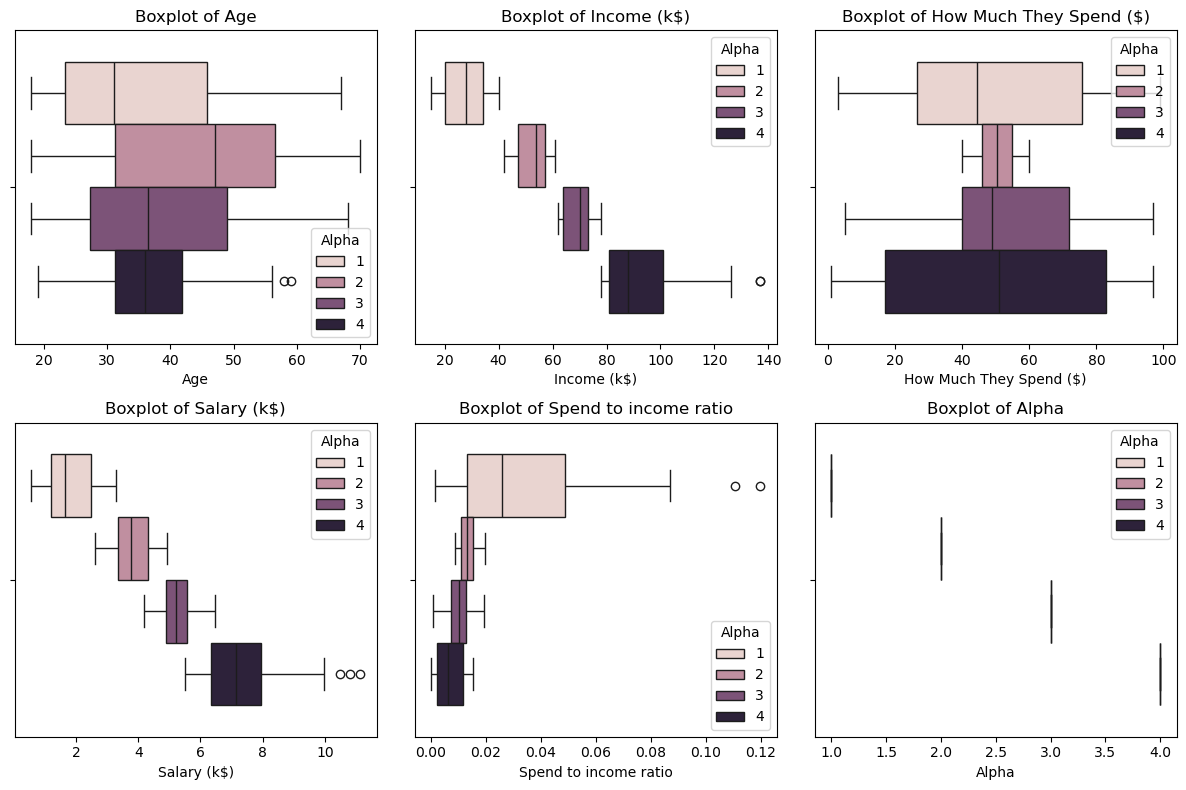

In [4]:
# Plotting the numerical features to visualize outliers
numerical_cols = customer.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols):
  plt.subplot(2, 3, i + 1)
  sns.boxplot(data=customer, x=col, hue="Alpha")
  plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

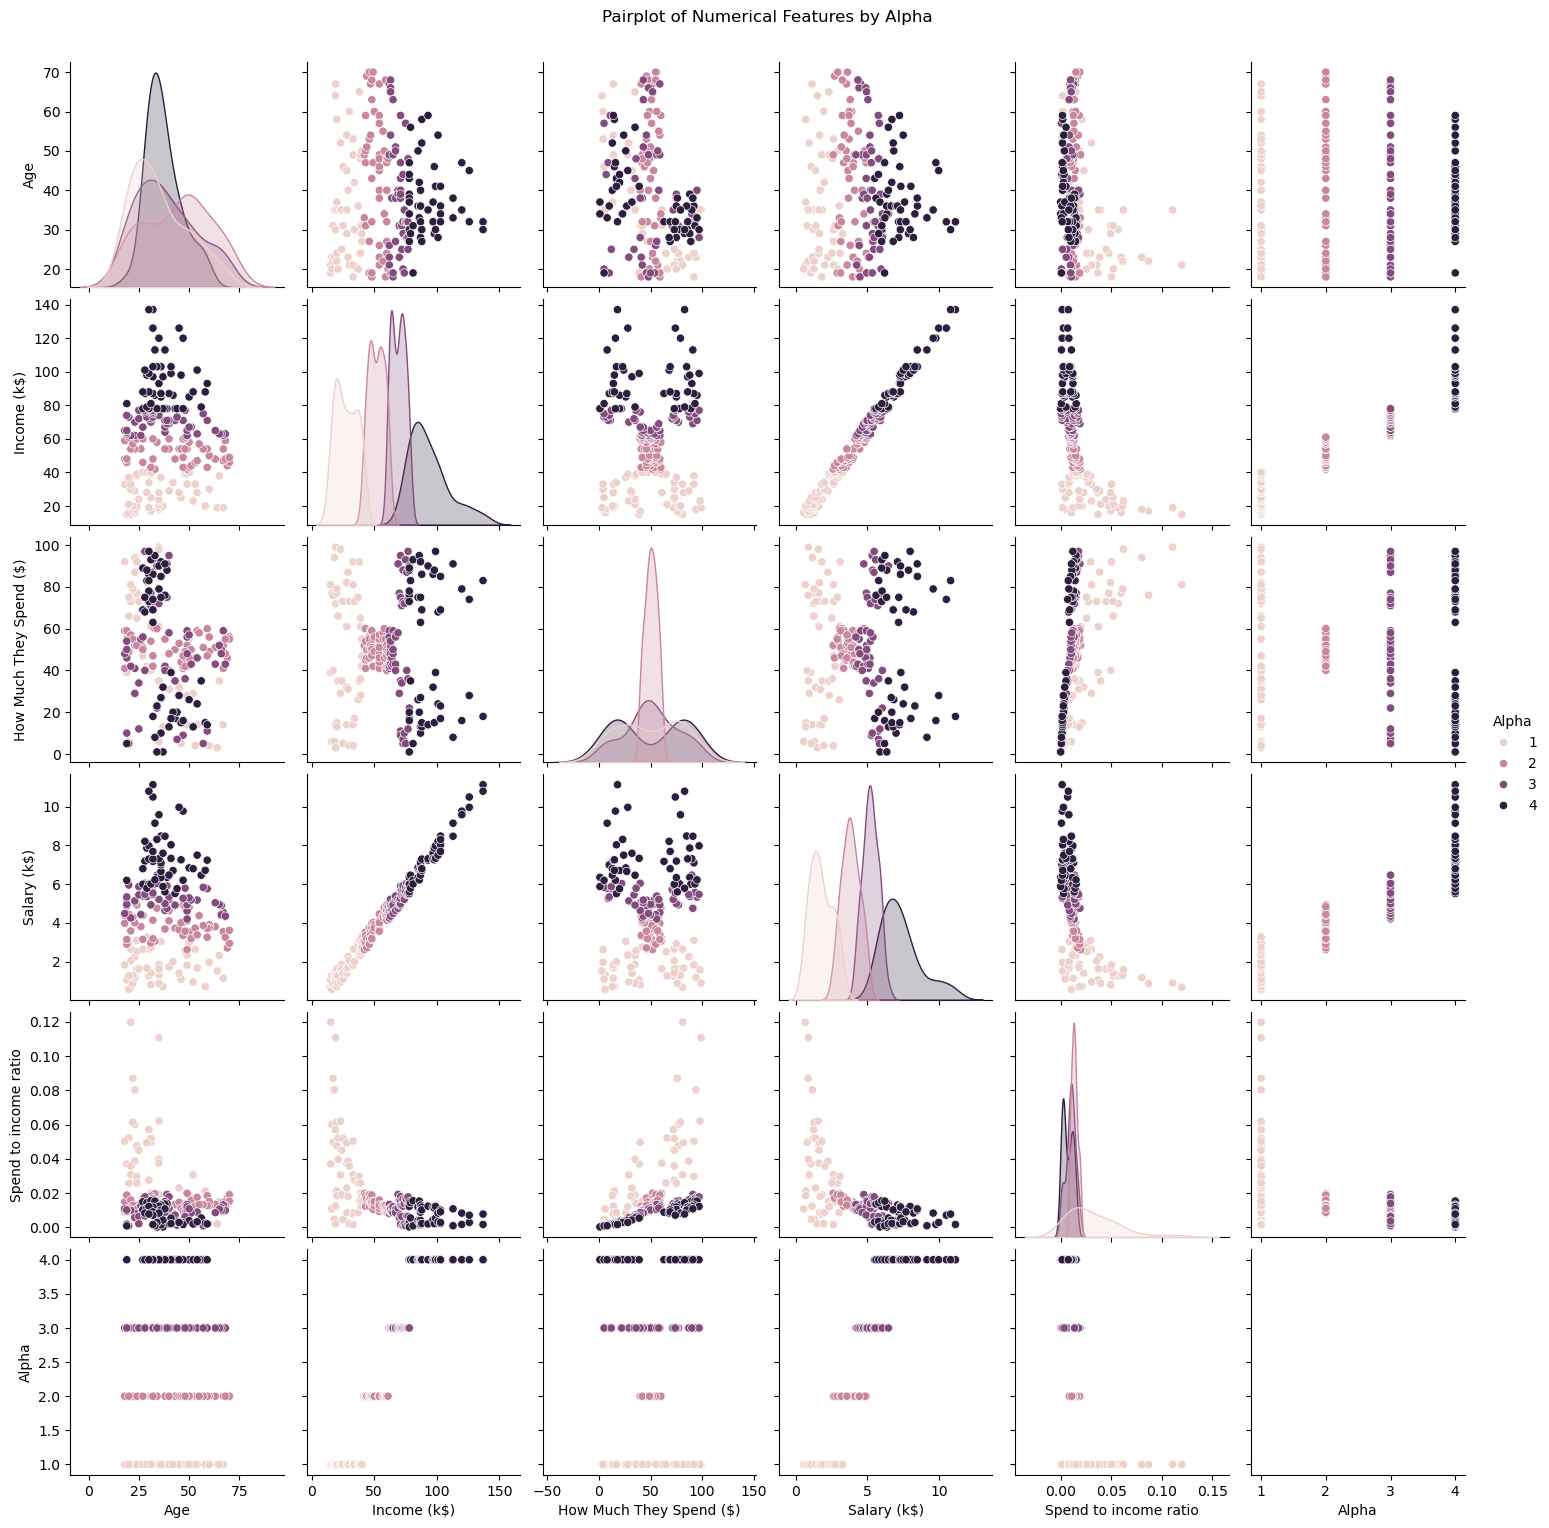

In [5]:
# pair plot to visualize relationships between numerical features
g = sns.pairplot(customer, hue='Alpha', vars=numerical_cols)
g.figure.suptitle('Pairplot of Numerical Features by Alpha', y=1.02)
plt.show()

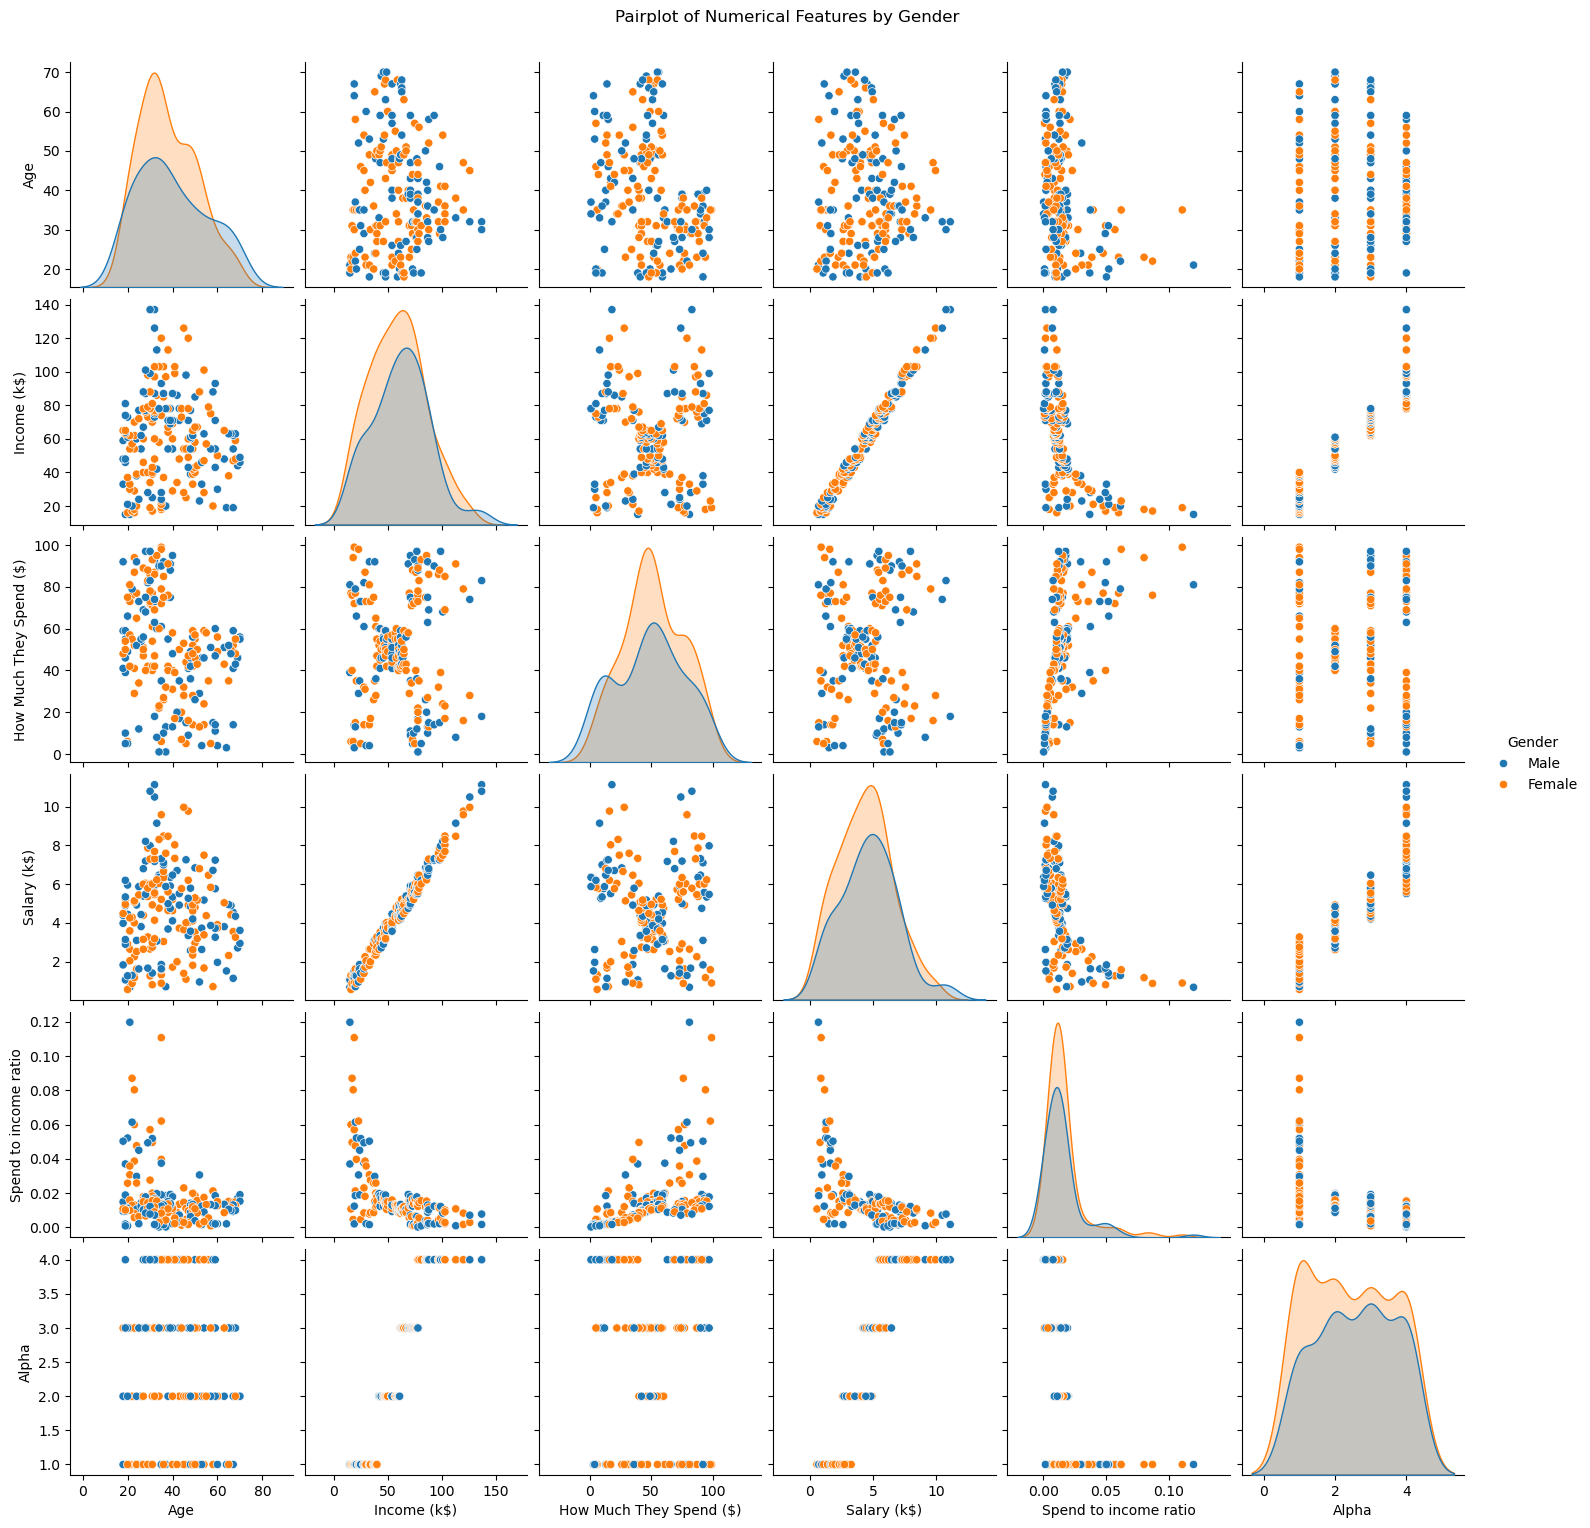

In [6]:
# pair plot to visualize relationships between numerical features
g = sns.pairplot(customer, hue='Gender', vars=numerical_cols)
g.figure.suptitle('Pairplot of Numerical Features by Gender', y=1.02)
plt.show()

# Data transformation

Transform the numerical features using StandardScaler to have 0 means and 1 variance

In [7]:
numerical_cols = customer.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = ["Gender"]

# preprocessing steps
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer,numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

pipeline_transform = Pipeline([
    ('preprocessor', preprocessor)
])


In [8]:
customer_transform = pipeline_transform.fit_transform(customer)

categorical_feature_names = pipeline_transform.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['Gender'])
numerical_feature_names = numerical_cols.tolist()
feature_names = np.concatenate([numerical_feature_names, categorical_feature_names]) 

customer_transform_df = pd.DataFrame(customer_transform, columns=feature_names)
display(customer_transform_df.head())
print("Descriptive statistics of transformed data:")
print(customer_transform_df.describe())

,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha,Gender_Male
0,-1.424569,-1.738999,-0.434801,-1.576835,1.240737,-1.341641,1.0
1,-1.281035,-1.738999,1.195704,-1.748301,6.098642,-1.341641,1.0
2,-1.352802,-1.700830,-1.715913,-1.799901,-0.301771,-1.341641,0.0
3,-1.137502,-1.700830,1.040418,-1.472983,2.588929,-1.341641,0.0
4,-0.563369,-1.662660,-0.395980,-1.689234,1.980859,-1.341641,0.0


Descriptive statistics of transformed data:
                Age   Income (k$)  How Much They Spend ($)   Salary (k$)  \
count  2.000000e+02  2.000000e+02             2.000000e+02  2.000000e+02   
mean  -1.021405e-16 -2.131628e-16            -1.465494e-16 -7.105427e-17   
std    1.002509e+00  1.002509e+00             1.002509e+00  1.002509e+00   
min   -1.496335e+00 -1.738999e+00            -1.910021e+00 -1.799901e+00   
25%   -7.248436e-01 -7.275093e-01            -5.997931e-01 -7.127949e-01   
50%   -2.045351e-01  3.587926e-02            -7.764312e-03  1.786994e-02   
75%    7.284319e-01  6.656748e-01             8.851316e-01  6.192318e-01   
max    2.235532e+00  2.917671e+00             1.894492e+00  2.985813e+00   

       Spend to income ratio         Alpha  Gender_Male  
count             200.000000  2.000000e+02   200.000000  
mean                0.000000 -7.105427e-17     0.440000  
std                 1.002509  1.002509e+00     0.497633  
min                -0.918524 -1.341641e

# choosing n_clusters using the elbow method

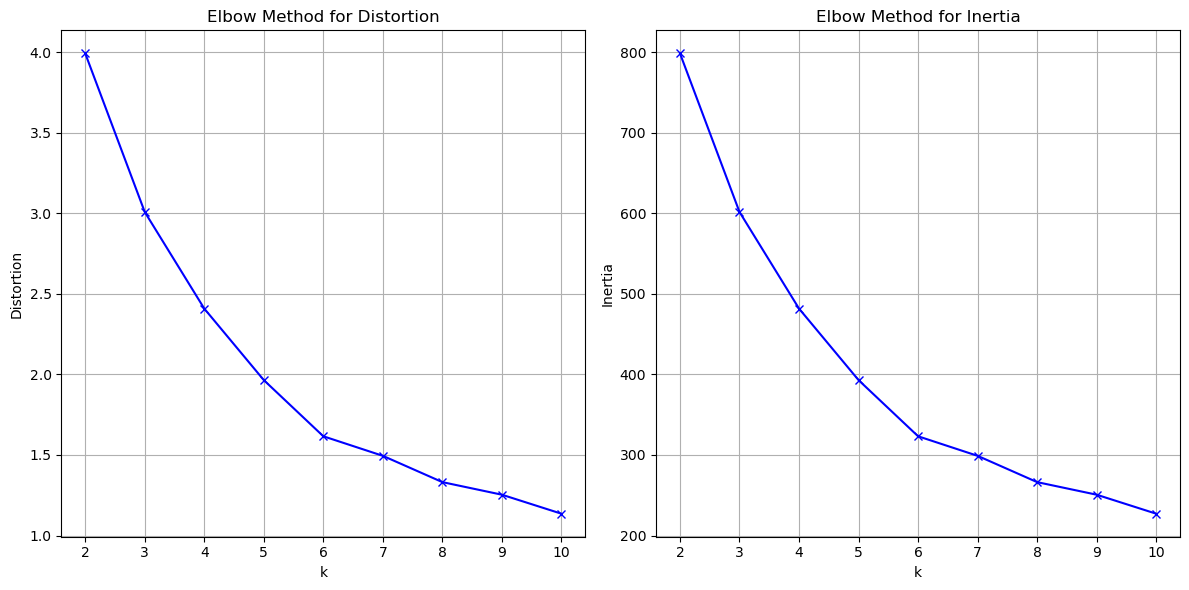

Distortion values:
2 : 3.993974002250099
3 : 3.0090533557254746
4 : 2.409006059069258
5 : 1.9649443127869315
6 : 1.6161449638524197
7 : 1.49473200100746
8 : 1.3314350833592774
9 : 1.253302051426047
10 : 1.1353551859504842

Inertia values:
2 : 798.7948004500197
3 : 601.810671145095
4 : 481.80121181385147
5 : 392.98886255738626
6 : 323.2289927704836
7 : 298.9464002014919
8 : 266.28701667185555
9 : 250.6604102852094
10 : 227.07103719009683


In [9]:
# Using Elbow method to choose n_cluster

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(2, 11)

for k in K:
  kmeanModel = KMeans(n_clusters=k, random_state=42).fit(customer_transform)
  distortions.append(
    sum(np.min(cdist(customer_transform, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / customer_transform.shape[0]
  )
  inertias.append(kmeanModel.inertia_)
  mapping1[k] = distortions[-1]
  mapping2[k] = inertias[-1]

# Plotting the elbow curve for distortions and inertias
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method for Distortion')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Inertia')
plt.grid()
plt.tight_layout()
plt.show()
plt.close()

print("Distortion values:")
for key, val in mapping1.items():
  print(f'{key} : {val}')

print()
print("Inertia values:")
for key, val in mapping2.items():
  print(f'{key} : {val}')

# choosing n_clusters using silhouette scores

Silhouette Score Analysis:
----------------------------------------
k= 2: Silhouette Score = 0.3088
k= 3: Silhouette Score = 0.3089
k= 4: Silhouette Score = 0.3335
k= 5: Silhouette Score = 0.3274
k= 6: Silhouette Score = 0.3505
k= 7: Silhouette Score = 0.3274
k= 8: Silhouette Score = 0.3221
k= 9: Silhouette Score = 0.2974
k=10: Silhouette Score = 0.2820

Optimal k based on Silhouette Score: 6 (Score: 0.3505)


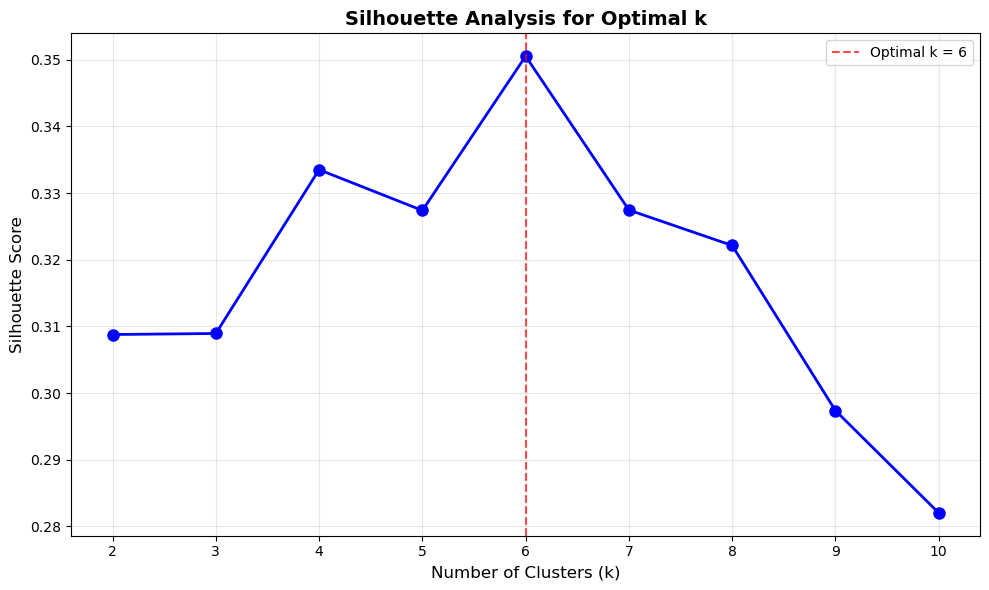

In [10]:
# Calculate silhouette scores for different k values
silhouette_scores = []
k_silhouette_mapping = {}

print("Silhouette Score Analysis:")
print("-" * 40)

for k in K:
  kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
  cluster_labels = kmeans.fit_predict(customer_transform)
  silhouette_avg = silhouette_score(customer_transform, cluster_labels, metric="euclidean")
  silhouette_scores.append(silhouette_avg)
  k_silhouette_mapping[k] = silhouette_avg
  print(f"k={k:2d}: Silhouette Score = {silhouette_avg:.4f}")

# Find optimal k based on silhouette score
if k_silhouette_mapping:  # Check if dictionary is not empty
  optimal_k = max(k_silhouette_mapping, key=k_silhouette_mapping.get)
  print(f"\nOptimal k based on Silhouette Score: {optimal_k} (Score: {k_silhouette_mapping[optimal_k]:.4f})")
else:
  print("No clusters evaluated!")
  optimal_k = 2

# Plotting silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.title('Silhouette Analysis for Optimal k', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(2, 11))

# Highlight optimal k
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, 
            label=f'Optimal k = {optimal_k}')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# Anomaly

In [11]:
def detect_anomalies(features: np.ndarray, kmeans: KMeans, n_anomalies: int = 5) -> tuple:
  """
  Detect anomalies based on distance to the closest centroid.
  
  Parameters
  ----------
  features : np.ndarray
    Feature matrix of shape (n_samples, n_features)
  kmeans : KMeans
    Fitted K-means model
  n_anomalies : int, optional
    Number of anomalies to detect, by default 5
  
  Returns
  -------
  tuple
    - anomaly_indices: Indices of detected anomalies
    - features_without_anomalies: Data with anomalies removed
    - anomaly_data: Data points identified as anomalies
    - distances: Distances from each point to nearest centroid

  Raises
  ------
  ValueError
    If n_anomalies is greater than the number of samples
  """
  # Validate input parameters
  if n_anomalies > features.shape[0]:
    raise ValueError(
      f"n_anomalies ({n_anomalies}) cannot be greater than "
      f"number of samples ({features.shape[0]})"
    )

  # Calculate distances to closest centroid for each point
  distances = kmeans.transform(features).min(axis=1)

  # Identify points with largest distances (potential anomalies)
  anomaly_indices = np.argsort(distances)[::-1][:n_anomalies]

  # Display detection statistics
  print("Anomaly Detection Statistics:")
  print("-" * 30)
  print(f"Total samples: {features.shape[0]}")
  print(f"Number of Anomalies set: {n_anomalies}")
  print(f"Mean distance to centroid: {distances.mean():.3f}")
  print(f"Std distance to centroid: {distances.std():.3f}")
  print(f"Max anomaly distance: {distances[anomaly_indices[0]]:.3f}")
  print(f"Min anomaly distance: {distances[anomaly_indices[-1]]:.3f}")
  
  return anomaly_indices, distances

# Detect anomalies


KMeans(n_clusters=6)
Anomaly Detection Statistics:
------------------------------
Total samples: 200
Number of Anomalies set: 5
Mean distance to centroid: 1.178
Std distance to centroid: 0.474
Max anomaly distance: 3.864
Min anomaly distance: 2.420


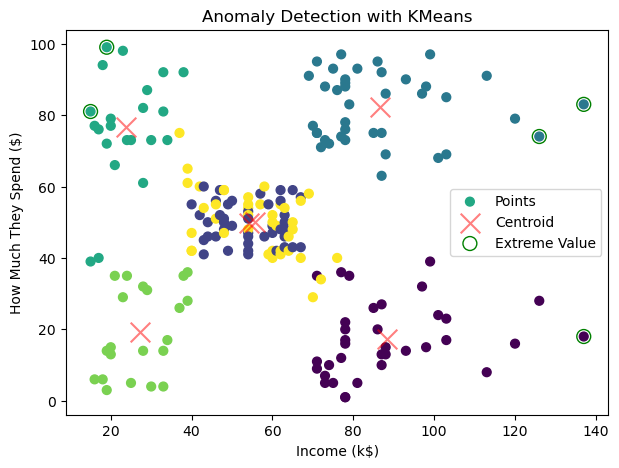

Anomalies from the original data:
     Gender  Age  Income (k$)  How Much They Spend ($)  Salary (k$)  \
1      Male   21           15                       81     0.676210   
11   Female   35           19                       99     0.893771   
198    Male   32          137                       18    11.133367   
199    Male   30          137                       83    10.796760   
197    Male   32          126                       74    10.497569   

     Spend to income ratio  Alpha  
1                 0.119785      1  
11                0.110767      1  
198               0.001617      4  
199               0.007687      4  
197               0.007049      4  


In [12]:
cluster = 6

kmeans = KMeans(n_clusters=cluster)
kmeans.fit(customer_transform)
print(kmeans)
y_kmeans = kmeans.predict(customer_transform)
centers = kmeans.cluster_centers_
# Use the fitted scaler from the pipeline
fitted_scaler = pipeline_transform.named_steps['preprocessor'].named_transformers_['num']
centers_inv = fitted_scaler.inverse_transform(centers[:, :-1])
sorted_idx, distances = detect_anomalies(customer_transform_df.values, kmeans, n_anomalies= 5)

# Visualize the results
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_title("Anomaly Detection with KMeans")
ax.scatter(customer["Income (k$)"], customer["How Much They Spend ($)"], c=y_kmeans, s=40, cmap='viridis',label='Points')
ax.scatter(centers_inv[:, 1], centers_inv[:, 2], label='Centroid', color='r',  marker='x',s=200, alpha=0.5)
ax.scatter(customer.iloc[sorted_idx]['Income (k$)'], 
           customer.iloc[sorted_idx]["How Much They Spend ($)"], 
           label='Extreme Value', edgecolors='g', facecolors='none', s=100)
ax.legend(loc='best')
plt.xlabel("Income (k$)")
plt.ylabel("How Much They Spend ($)")
plt.show()
# It's easy to remove these points if we like:
# new_Customer = np.delete(customer_transform, sorted_idx, axis=0)
new_Customer_transformed = customer_transform_df.drop(customer_transform_df.index[sorted_idx])
new_Customer = customer.drop(customer.index[sorted_idx])
# Or to extract the anomalies
anomaly = customer.iloc[sorted_idx]
anomaly_transformed = customer_transform_df.iloc[sorted_idx]
print("Anomalies from the original data:")
print(anomaly)

# PCA

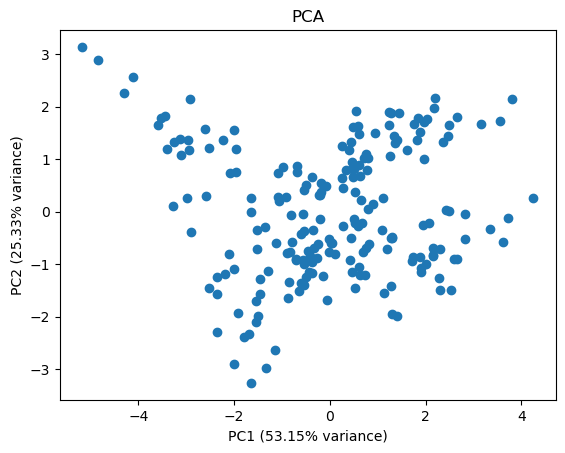

In [13]:
# Apply PCA with two components (for 2D visualization)
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(customer_transform)
# Plot the results
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1])
plt.title('PCA')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.show()

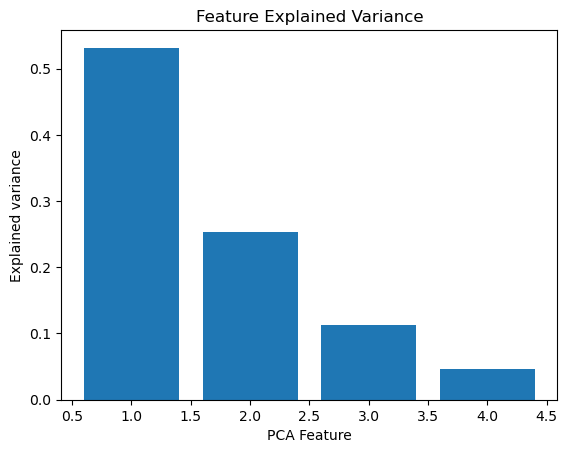

In [14]:
# Analyzing explained variance for customer dataset features
pca = PCA(n_components=4)
# Fit and transform data
pca_features = pca.fit_transform(customer_transform)
# Bar plot of explained_variance_ratio_
plt.bar(range(1,len(pca.explained_variance_ratio_)+1),
pca.explained_variance_ratio_)
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

In [15]:
def comprehensive_pca_kmeans_analysis(data, pca_components=range(2, 6), n_clusters=range(2, 11)):
  results = {}
  
  print("Comprehensive PCA + KMeans Analysis")
  print("=" * 50)
  print(f"Testing PCA components: {list(pca_components)}")
  print(f"Testing cluster numbers: {list(n_clusters)}")
  print(f"Total combinations: {len(pca_components) * len(n_clusters)}")
  print("-" * 50)
  
  # Test all combinations of PCA components and clusters
  for n_comp in pca_components:
    for n_clust in n_clusters:
      # Create pipeline using the existing preprocessor
      pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=n_comp, random_state=42)),
        ('kmeans', KMeans(n_clusters=n_clust, random_state=42, n_init=10))
      ])

      # Fit pipeline and get cluster labels
      cluster_labels = pipeline.fit_predict(data)

      # Get PCA-transformed data for silhouette calculation
      X_preprocessed = pipeline.named_steps['preprocessor'].transform(data)
      X_pca = pipeline.named_steps['pca'].transform(X_preprocessed)

      # Calculate silhouette score
      silhouette_avg = silhouette_score(X_pca, cluster_labels)

      # Get explained variance ratio
      explained_variance = pipeline.named_steps['pca'].explained_variance_ratio_.sum()

      # Store results
      key = f"PCA_{n_comp}_KMeans_{n_clust}"
      results[key] = {
        'pca_components': n_comp,
        'n_clusters': n_clust,
        'silhouette_score': silhouette_avg,
        'explained_variance': explained_variance,
        'pipeline': pipeline,
        'cluster_labels': cluster_labels,
        'X_transformed': X_pca
      }

      print(f"PCA={n_comp}, Clusters={n_clust:2d}: "
            f"Silhouette={silhouette_avg:.4f}, "
            f"Variance={explained_variance:.3f}")
  
  return results

# Run comprehensive analysis with raw customer data
comprehensive_results = comprehensive_pca_kmeans_analysis(customer)

print("\n" + "=" * 60)
print("ANALYSIS SUMMARY")
print("=" * 60)

# Find best combinations
best_silhouette = max(comprehensive_results.items(), key=lambda x: x[1]['silhouette_score'])
best_variance = max(comprehensive_results.items(), key=lambda x: x[1]['explained_variance'])

print(f"\nBest Silhouette Score:")
print(f"  Configuration: {best_silhouette[0]}")
print(f"  Score: {best_silhouette[1]['silhouette_score']:.4f}")
print(f"  PCA Components: {best_silhouette[1]['pca_components']}")
print(f"  Clusters: {best_silhouette[1]['n_clusters']}")
print(f"  Explained Variance: {best_silhouette[1]['explained_variance']:.3f}")

print(f"\nHighest Explained Variance:")
print(f"  Configuration: {best_variance[0]}")
print(f"  Variance: {best_variance[1]['explained_variance']:.3f}")
print(f"  PCA Components: {best_variance[1]['pca_components']}")
print(f"  Clusters: {best_variance[1]['n_clusters']}")
print(f"  Silhouette Score: {best_variance[1]['silhouette_score']:.4f}")

Comprehensive PCA + KMeans Analysis
Testing PCA components: [2, 3, 4, 5]
Testing cluster numbers: [2, 3, 4, 5, 6, 7, 8, 9, 10]
Total combinations: 36
--------------------------------------------------
PCA=2, Clusters= 2: Silhouette=0.3941, Variance=0.785
PCA=2, Clusters= 3: Silhouette=0.4091, Variance=0.785
PCA=2, Clusters= 4: Silhouette=0.4310, Variance=0.785
PCA=2, Clusters= 5: Silhouette=0.4065, Variance=0.785
PCA=2, Clusters= 6: Silhouette=0.4279, Variance=0.785
PCA=2, Clusters= 7: Silhouette=0.4195, Variance=0.785
PCA=2, Clusters= 8: Silhouette=0.4211, Variance=0.785
PCA=2, Clusters= 9: Silhouette=0.4236, Variance=0.785
PCA=2, Clusters=10: Silhouette=0.4147, Variance=0.785
PCA=3, Clusters= 2: Silhouette=0.3389, Variance=0.898
PCA=3, Clusters= 3: Silhouette=0.3483, Variance=0.898
PCA=3, Clusters= 4: Silhouette=0.3761, Variance=0.898
PCA=3, Clusters= 5: Silhouette=0.3883, Variance=0.898
PCA=3, Clusters= 6: Silhouette=0.4247, Variance=0.898
PCA=3, Clusters= 7: Silhouette=0.3941, Vari

In [16]:
n_comp = 2
n_clust = 4

pipeline = Pipeline([
  ('preprocessor', preprocessor),
  ('pca', PCA(n_components=n_comp, random_state=42)),
  ('kmeans', KMeans(n_clusters=n_clust, random_state=42, n_init=10))
])

cluster_labels = pipeline.fit_predict(customer)
customer_predicted = customer.copy()

customer_predicted['Cluster'] = cluster_labels
print("\nPredicted Clusters:")
print(customer_predicted)

distances = pipeline.transform(customer).min(axis=1)
n_anomalies = 5

# Identify points with largest distances (potential anomalies)
anomaly_indices = np.argsort(distances)[::-1][:n_anomalies]

# Display anomaly statistics
print("\nAnomaly Detection Statistics:")
print("-" * 30)
print(f"Total samples: {customer.shape[0]}")
print(f"Number of Anomalies set: {n_anomalies}")
print(f"Mean distance to centroid: {distances.mean():.3f}")
print(f"Std distance to centroid: {distances.std():.3f}")
print(f"Max anomaly distance: {distances[anomaly_indices[0]]:.3f}")
print(f"Min anomaly distance: {distances[anomaly_indices[-1]]:.3f}")  

customer_predicted.iloc[anomaly_indices, :]



Predicted Clusters:
     Gender  Age  Income (k$)  How Much They Spend ($)  Salary (k$)  \
0      Male   19           15                       39     1.054960   
1      Male   21           15                       81     0.676210   
2    Female   20           16                        6     0.562232   
3    Female   23           16                       77     1.284359   
4    Female   31           17                       40     0.806683   
..      ...  ...          ...                      ...          ...   
195  Female   35          120                       79     9.581893   
196  Female   45          126                       28     9.966931   
197    Male   32          126                       74    10.497569   
198    Male   32          137                       18    11.133367   
199    Male   30          137                       83    10.796760   

     Spend to income ratio  Alpha  Cluster  
0                 0.036968      1        2  
1                 0.119785      1   

,Gender,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha,Cluster
198,Male,32,137,18,11.133367,0.001617,4,3
1,Male,21,15,81,0.676210,0.119785,1,2
199,Male,30,137,83,10.796760,0.007687,4,1
8,Male,64,19,3,1.517408,0.001977,1,0
10,Male,67,19,14,1.137197,0.012311,1,0


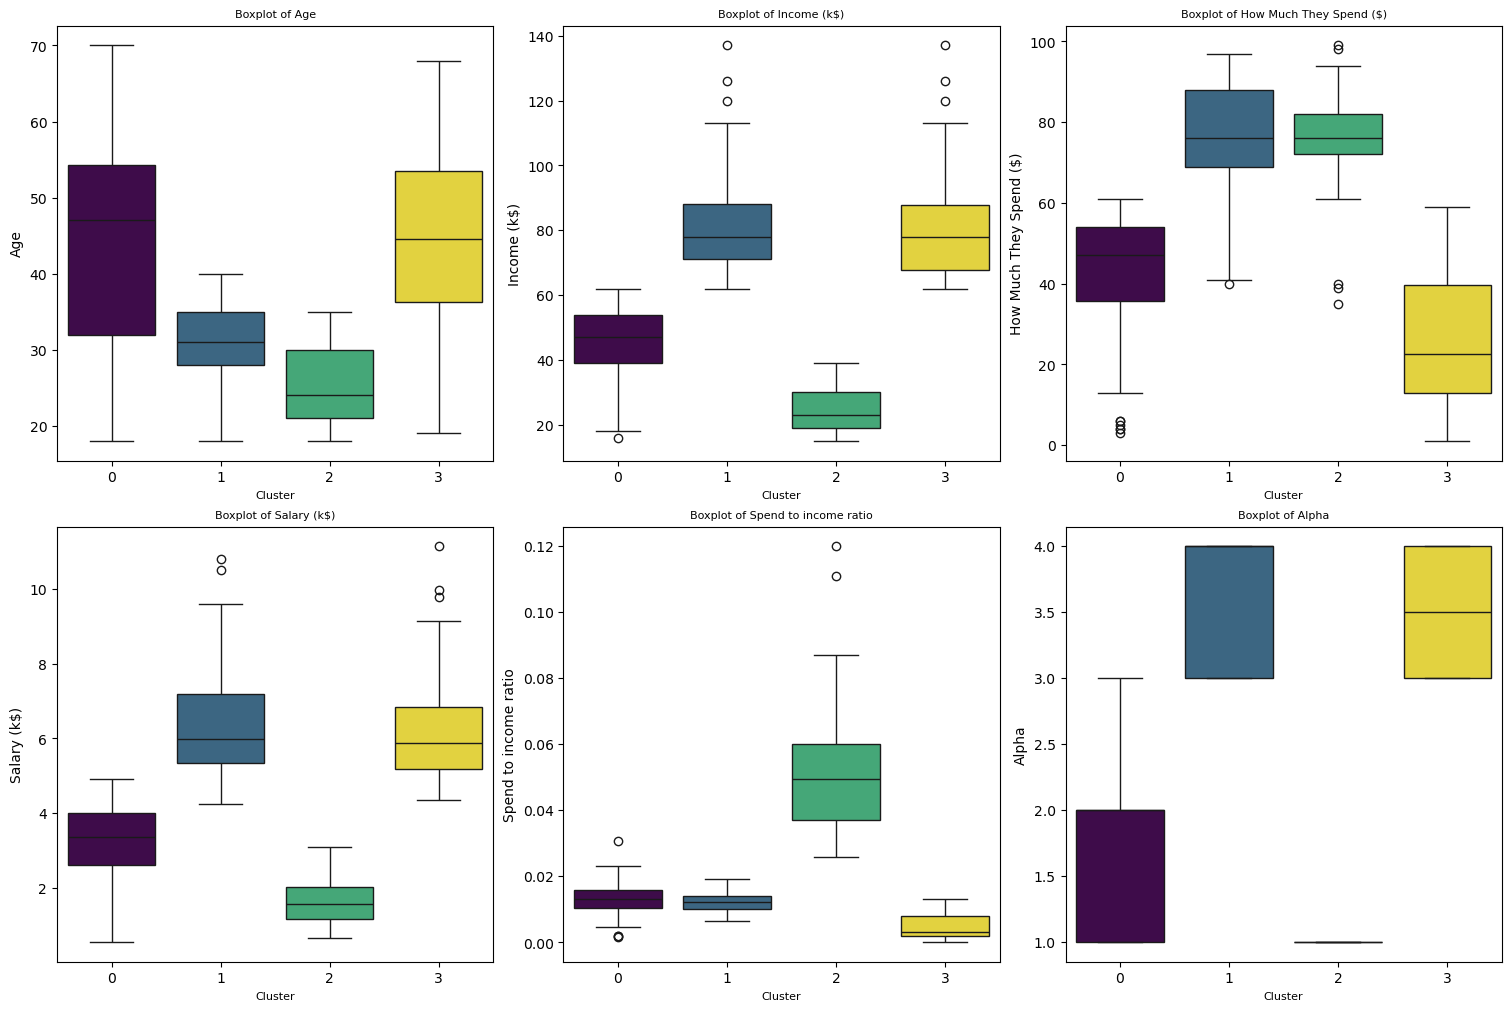

In [17]:
# Boxplots with Cluster_3D as hue
plt.figure(figsize=(15, 10), constrained_layout=True)

# Get numerical columns from customer_predicted
numerical_cols = customer_predicted.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Remove cluster columns from numerical_cols if they exist
numerical_cols = [col for col in numerical_cols if not col.startswith('Cluster')]


for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=customer_predicted, x='Cluster', y=col, 
                hue='Cluster', palette='viridis')
    plt.title(f'Boxplot of {col}', fontsize=8)
    plt.xlabel('Cluster', fontsize=8)
    plt.ylabel(col)
    plt.legend([],[], frameon=False)

plt.show()

In [18]:


def visualize(pipeline, data, n_anomalies = 5):
  clusters = pipeline.fit_predict(data)
  X_preprocessed = pipeline.named_steps['preprocessor'].transform(data)
  X_pca = pipeline.named_steps['pca'].transform(X_preprocessed)
  # Get PCA object for variance ratio information
  pca_component = pipeline.named_steps['pca']
  # Detect anomalies using the PCA-transformed data
  distances = pipeline.transform(data).min(axis=1)
  # Identify points with largest distances (potential anomalies)
  anomaly_indices = np.argsort(distances)[::-1][:n_anomalies]
  # len of pca_component
  print(f"Number of PCA components: {pca_component.n_components_}")
  if pca_component.n_components_ == 2:
    # 2D visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=50, label='points')
    # Plot centroids from the pipeline
    centroids = pipeline.named_steps['kmeans'].cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                c='red', marker='x', s=200, alpha=0.8, label='Centroids')
    # Plot anomalies
    plt.scatter(X_pca[anomaly_indices, 0], X_pca[anomaly_indices, 1], 
            edgecolors='r', facecolors='none', s=150, label='Anomalies')
    plt.title('PCA + KMeans Clustering (2D)')
    plt.xlabel(f'PC1 ({pca_component.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca_component.explained_variance_ratio_[1]:.2%} variance)')
    # plt.colorbar(label='Cluster')
    plt.legend()
    plt.show()
  elif pca_component.n_components_ >= 3:
    from mpl_toolkits import mplot3d

    # Magic line to make your 3-d graph pop out,
    # and you can interactively rotate it.
    %matplotlib tk

    # 3D visualization
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='viridis', s=50, label='points')
    # Plot centroids from the pipeline
    centroids = pipeline.named_steps['kmeans'].cluster_centers_
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
               c='red', marker='x', s=200, alpha=0.8, label='Centroids')
    # Plot anomalies
    ax.scatter(X_pca[anomaly_indices, 0], X_pca[anomaly_indices, 1], 
               X_pca[anomaly_indices, 2], edgecolors='r', facecolors='none', s=150, label='Anomalies')
    ax.set_title('PCA + KMeans Clustering (3D)')
    ax.set_xlabel(f'PC1 ({pca_component.explained_variance_ratio_[0]:.2%} variance)')
    ax.set_ylabel(f'PC2 ({pca_component.explained_variance_ratio_[1]:.2%} variance)')
    ax.set_zlabel(f'PC3 ({pca_component.explained_variance_ratio_[2]:.2%} variance)')
    plt.legend()
    plt.show()

  return



Number of PCA components: 2


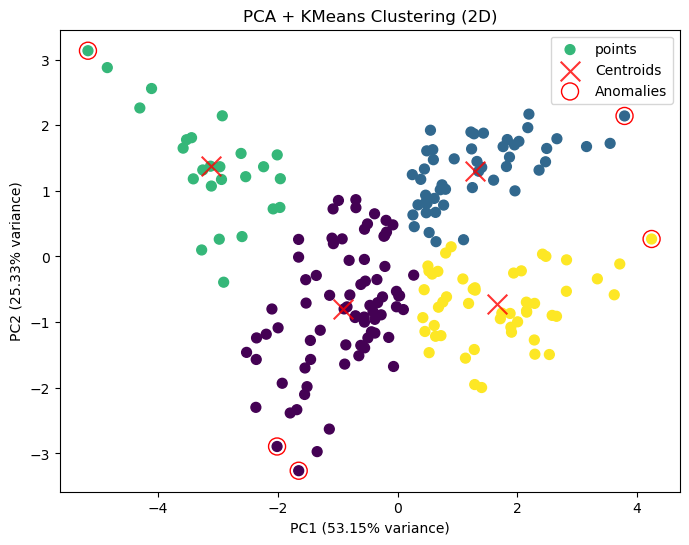

In [19]:
visualize(pipeline, customer)
